
Modelos de prediccion para material Particulado (PM 2,5)
---



Cargamos librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Dense

Importamos la base que contiene el material pariculado

In [ ]:
c_df = pd.read_excel("/content/drive/MyDrive/datos.redes/Cohaique16-23-03 estacion 2.xlsx")


Vemos cuantos NAN tengo por cada columna

In [ ]:
c_df = c_df.set_index(pd.to_datetime(c_df.index))

c_df.isna().sum()/len(c_df)*100

,0
FECHA (YYMMDD),0.0
HORA (HHMM),0.0
Presion atmosferica hpa,0.0
Humedad relativa %,0.0
"PM2,5",0.0
Temperatura ºc,0.0
Velocidad del Viento m/s,0.0


Para este caso se hizo un preprocesamiento antes de ingresar a py

In [ ]:
# Convertir las columnas 'FECHA (YYMMDD)' y 'HORA (HHMM)' a enteros
c_df['FECHA (YYMMDD)'] = c_df['FECHA (YYMMDD)'].astype(int)
c_df['HORA (HHMM)'] = c_df['HORA (HHMM)'].astype(int)
# Convertir las columnas de fecha y hora en una sola columna datetime
c_df['FECHA (YYMMDD)'] = pd.to_datetime(c_df['FECHA (YYMMDD)'].astype(str), format='%y%m%d')
c_df['HORA (HHMM)'] = c_df['HORA (HHMM)'].apply(lambda x: f"{x:04d}")
c_df['HORA (HHMM)'] = pd.to_datetime(c_df['HORA (HHMM)'], format='%H%M').dt.time

# Combinar las columnas de fecha y hora en una sola columna datetime
c_df['Fecha_Hora'] = c_df.apply(lambda row: pd.Timestamp.combine(row['FECHA (YYMMDD)'], row['HORA (HHMM)']), axis=1)

Agregamos el dato de año y semana para obtener mas variables para predecir el material particulado

In [ ]:
# Agregar día del año (DoY) y día de la semana (DoW)
c_df['DoY'] = c_df['Fecha_Hora'].dt.dayofyear
c_df['DoW'] = c_df['Fecha_Hora'].dt.dayofweek + 1  # Ajustar para que comience en 1

In [ ]:
c_df

,FECHA (YYMMDD),HORA (HHMM),Presion atmosferica hpa,Humedad relativa %,"PM2,5",Temperatura ºc,Velocidad del Viento m/s,Fecha_Hora,DoY,DoW
1970-01-01 00:00:00.000000000,2016-01-01,01:00:00,970.000,69.0000,12.89000,10.80000,1.400000,2016-01-01 01:00:00,1,5
1970-01-01 00:00:00.000000001,2016-01-01,02:00:00,970.000,70.0000,10.51000,10.30000,1.200000,2016-01-01 02:00:00,1,5
1970-01-01 00:00:00.000000002,2016-01-01,03:00:00,969.000,72.0000,9.01999,9.89999,1.100000,2016-01-01 03:00:00,1,5
1970-01-01 00:00:00.000000003,2016-01-01,04:00:00,969.000,74.0000,6.69900,9.39999,1.100000,2016-01-01 04:00:00,1,5
1970-01-01 00:00:00.000000004,2016-01-01,05:00:00,969.000,75.0000,8.14998,9.09999,1.200000,2016-01-01 05:00:00,1,5
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000063522,2023-03-31,19:00:00,970.002,79.1283,83.00000,6.20217,0.178656,2023-03-31 19:00:00,90,5
1970-01-01 00:00:00.000063523,2023-03-31,20:00:00,969.084,84.1835,41.00000,5.48234,0.814763,2023-03-31 20:00:00,90,5
1970-01-01 00:00:00.000063524,2023-03-31,21:00:00,968.168,82.7294,39.00000,5.20634,0.529710,2023-03-31 21:00:00,90,5
1970-01-01 00:00:00.000063525,2023-03-31,22:00:00,966.750,85.9333,71.00000,4.84167,0.682912,2023-03-31 22:00:00,90,5


In [ ]:
c_df.set_index('Fecha_Hora', inplace=True)

In [ ]:
c_df.drop(columns=['FECHA (YYMMDD)', 'HORA (HHMM)'], inplace=True)

In [ ]:
c_df_mean = c_df.resample('D',kind = 'timestamp').mean()

<ipython-input-11-b6dbcb3d848b>:1: FutureWarning: The 'kind' keyword in DataFrame.resample is deprecated and will be removed in a future version. Explicitly cast the index to the desired type instead
  c_df_mean = c_df.resample('D',kind = 'timestamp').mean()


In [ ]:
c_df_mean

,Presion atmosferica hpa,Humedad relativa %,"PM2,5",Temperatura ºc,Velocidad del Viento m/s,DoY,DoW
Fecha_Hora,,,,,,,
2016-01-01,967.217391,50.652174,12.269606,16.852173,2.530434,1.0,5.0
2016-01-02,968.541667,57.500000,11.311165,12.979166,3.645832,2.0,6.0
2016-01-03,972.625000,46.458333,9.857829,11.112498,3.575000,3.0,7.0
2016-01-04,975.458333,60.541667,12.177230,11.687498,4.012499,4.0,1.0
2016-01-05,978.166667,52.125000,8.990664,14.291666,2.937499,5.0,2.0
...,...,...,...,...,...,...,...
2023-03-27,958.688125,69.907342,15.875000,8.560669,2.621049,86.0,1.0
2023-03-28,960.847458,82.498096,34.208333,2.887950,1.667895,87.0,2.0
2023-03-29,968.422958,76.705046,23.395833,4.116550,1.798600,88.0,3.0


Visualizamos para saber si tenemos datos atipicos

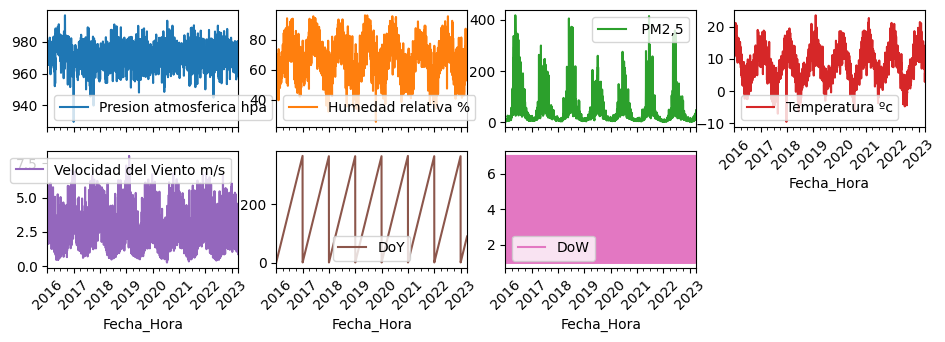

In [ ]:
c_df_mean.plot(subplots = True, layout = (4,4), figsize = (7*(1+np.sqrt(5))/2,7), rot=45);

In [ ]:
df_predictores = c_df_mean
df_predictores

,Presion atmosferica hpa,Humedad relativa %,"PM2,5",Temperatura ºc,Velocidad del Viento m/s,DoY,DoW
Fecha_Hora,,,,,,,
2016-01-01,967.217391,50.652174,12.269606,16.852173,2.530434,1.0,5.0
2016-01-02,968.541667,57.500000,11.311165,12.979166,3.645832,2.0,6.0
2016-01-03,972.625000,46.458333,9.857829,11.112498,3.575000,3.0,7.0
2016-01-04,975.458333,60.541667,12.177230,11.687498,4.012499,4.0,1.0
2016-01-05,978.166667,52.125000,8.990664,14.291666,2.937499,5.0,2.0
...,...,...,...,...,...,...,...
2023-03-27,958.688125,69.907342,15.875000,8.560669,2.621049,86.0,1.0
2023-03-28,960.847458,82.498096,34.208333,2.887950,1.667895,87.0,2.0
2023-03-29,968.422958,76.705046,23.395833,4.116550,1.798600,88.0,3.0


Verificamos que tipo de dato ahi en la columna PM2,5 en el primer dato

In [ ]:
print(type(df_predictores[ " PM2,5"][1]))

<class 'numpy.float64'>


<ipython-input-15-228a693099bb>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(df_predictores[ " PM2,5"][1]))


In [ ]:
df_target = c_df_mean[ " PM2,5"]

Desplazamos uno hacia abajo ya que apartir de todas las columnas de los primeros datos quiero predecir el futuro del otro dia

In [ ]:
df_target = df_target.shift(-1)

In [ ]:
df_target.drop(df_target.index[-1], inplace=True)
df_predictores.drop(c_df_mean.index[-1], inplace=True)
df_predictores

,Presion atmosferica hpa,Humedad relativa %,"PM2,5",Temperatura ºc,Velocidad del Viento m/s,DoY,DoW
Fecha_Hora,,,,,,,
2016-01-01,967.217391,50.652174,12.269606,16.852173,2.530434,1.0,5.0
2016-01-02,968.541667,57.500000,11.311165,12.979166,3.645832,2.0,6.0
2016-01-03,972.625000,46.458333,9.857829,11.112498,3.575000,3.0,7.0
2016-01-04,975.458333,60.541667,12.177230,11.687498,4.012499,4.0,1.0
2016-01-05,978.166667,52.125000,8.990664,14.291666,2.937499,5.0,2.0
...,...,...,...,...,...,...,...
2023-03-26,973.923542,54.488746,12.041667,9.769084,2.133669,85.0,7.0
2023-03-27,958.688125,69.907342,15.875000,8.560669,2.621049,86.0,1.0
2023-03-28,960.847458,82.498096,34.208333,2.887950,1.667895,87.0,2.0


In [ ]:
#Guardar los indices de fechas
dates = df_predictores.index

como se observa se desplazo el traget que es el objetivo que yo quiero y es la salida de la red neuronal par que aprenda

In [ ]:
df_target

,"PM2,5"
Fecha_Hora,
2016-01-01,11.311165
2016-01-02,9.857829
2016-01-03,12.177230
2016-01-04,8.990664
2016-01-05,7.918998
...,...
2023-03-26,15.875000
2023-03-27,34.208333
2023-03-28,23.395833


dividimos los datos en 80 y 20 pero de forma manual, por los datos de tiempo no de forma random

In [ ]:
#dividir los datos en 80 y 20
# División de datos en conjuntos de entrenamiento y prueba
train_size = int(len(df_predictores) * 0.8)
train_data = df_predictores[:train_size]
test_data = df_predictores[train_size:]

# División de datos en conjuntos de entrenamiento y prueba
train_size1 = int(len(df_target) * 0.8)
train_data1 = df_target[:train_size1]
test_data1 = df_target[train_size1:]


# Obtener matrices de características de entrada y objetivo para entrenamiento
X_train = train_data
y_train = train_data1
X_test = test_data
y_test = test_data1

print(X_train)
print(y_train)

            Presion atmosferica hpa  Humedad relativa %      PM2,5  \
Fecha_Hora                                                           
2016-01-01               967.217391           50.652174  12.269606   
2016-01-02               968.541667           57.500000  11.311165   
2016-01-03               972.625000           46.458333   9.857829   
2016-01-04               975.458333           60.541667  12.177230   
2016-01-05               978.166667           52.125000   8.990664   
...                             ...                 ...        ...   
2021-10-12               969.931125           59.436029  26.916667   
2021-10-13               959.892792           70.170596  21.750000   
2021-10-14               969.499958           65.134504  17.750000   
2021-10-15               971.868875           66.235704  10.750000   
2021-10-16               975.031833           62.027983  10.166667   

            Temperatura ºc  Velocidad del Viento m/s    DoY  DoW  
Fecha_Hora            

In [ ]:
#Fechas para entreno y prueba
train_dates = dates[:train_size]
test_dates = dates[train_size:]

In [ ]:
print(X_test)
print(y_test)

            Presion atmosferica hpa  Humedad relativa %      PM2,5  \
Fecha_Hora                                                           
2021-10-17               982.125583           59.706292  14.541667   
2021-10-18               978.343875           66.956262  10.208333   
2021-10-19               974.808583           66.451567  12.083333   
2021-10-20               970.708625           64.417637   9.791667   
2021-10-21               976.977208           57.345679  15.625000   
...                             ...                 ...        ...   
2023-03-26               973.923542           54.488746  12.041667   
2023-03-27               958.688125           69.907342  15.875000   
2023-03-28               960.847458           82.498096  34.208333   
2023-03-29               968.422958           76.705046  23.395833   
2023-03-30               976.321083           71.517692  42.333333   

            Temperatura ºc  Velocidad del Viento m/s    DoY  DoW  
Fecha_Hora            

REDES NEURONALES MULTICAPA
---



ARQUITECTURA MLP

In [ ]:
#definir modelo
model_MLP = tf.keras.models.Sequential()

#model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(30, activation = tf.keras.activations.relu)) # 1ra oculta
model_MLP.add(Dense(80, activation = tf.keras.activations.relu))
model_MLP.add(Dense(30, activation = tf.keras.activations.relu)) # 3ra oculta

## Última capa indica tarea de la red
model_MLP.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

model_MLP.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['mean_absolute_error','mean_squared_error','mean_absolute_percentage_error'])

input_shape = X_train.shape
model_MLP.build(input_shape)

model_MLP.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (2116, 30)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (2116, 80)                  │           2,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (2116, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (2116, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,181 (20.24 KB)

 Trainable params: 5,181 (20.24 KB)

 Non-trainable params: 0 (0.00 B)

ENTRENAMIENTO MLP

In [ ]:
MLP = model_MLP.fit(X_train, y_train, epochs = 250, batch_size = 50)

Epoch 1/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49392.3516 - mean_absolute_error: 179.9345 - mean_absolute_percentage_error: 854.2933 - mean_squared_error: 49392.3516 
Epoch 2/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3170.7305 - mean_absolute_error: 39.2754 - mean_absolute_percentage_error: 208.9261 - mean_squared_error: 3170.7305
Epoch 3/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2270.1323 - mean_absolute_error: 31.6786 - mean_absolute_percentage_error: 152.1271 - mean_squared_error: 2270.1323
Epoch 4/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1565.3293 - mean_absolute_error: 25.2974 - mean_absolute_percentage_error: 103.3984 - mean_squared_error: 1565.3293
Epoch 5/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1426.7617 - mean_absolute_error: 22.8584 - mean_absolute_percentage_error: 74.0328 - mean_squared_error: 1426.7617
Epoch 6/250
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1376.8812 - mean_absolute_error: 21.2494 - mean_absolute_percen

METRICAS

In [ ]:
loss, mae, mse, mape = model_MLP.evaluate(X_test, y_test)
print("Loss:", loss)
print("MAE:", mae)
print("MSE:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 621.5188 - mean_absolute_error: 11.7586 - mean_absolute_percentage_error: 64.5217 - mean_squared_error: 621.5188
Loss: 741.8707275390625
MAE: 13.674568176269531
MSE: 741.8707275390625


PESOS OBTENIDOS APARTIR DEL ENTRENAMIENTO

In [ ]:
# Obtener los pesos del modelo MLP
weights = model_MLP.get_weights()

# Mostrar los pesos para cada capa
for i, weight in enumerate(weights):
    print(f'Pesos de la capa {i + 1}: {weight.shape}')
    print(weight)

Pesos de la capa 1: (7, 30)
[[-0.37436974  0.17775728 -0.02573862 -0.09834617  0.01903476 -0.3175278
  -0.00700838  0.20146136  0.14918321  0.01448957  0.02281059  0.14269605
  -0.3310279  -0.23903146 -0.06420079 -0.28642815  0.13717651  0.06719533
  -0.0533658   0.18955694  0.05843995 -0.27473015 -0.10965058 -0.23000646
   0.20953996  0.3209557  -0.17537083 -0.16773865 -0.36806008  0.2552777 ]
 [ 0.20585513  0.22483084  0.24773988 -0.38139352  0.03212005 -0.01924399
  -0.13354164  0.1906531  -0.20894408  0.5409337  -0.17783047 -0.00683354
   0.26374012 -0.22258617  0.01536471 -0.1297434   0.24504547  0.35881698
  -0.27706522 -0.3736178   0.08126271 -0.3730201   0.37177384  0.05805385
  -0.67343855 -0.42703983 -0.31438452  0.24662352 -0.06229413 -0.08342361]
 [-0.39497206 -0.34586263  0.35784823  0.41509676  0.50707066 -0.10954392
  -0.1732007  -0.3921623  -0.35617706 -0.34748676 -0.10166715 -0.15253991
  -0.03984478 -0.22063525  0.10366058 -0.34308797  0.38069367 -0.17408751
  -0.3836

PREDICION CON EL 20% DE MIS DATOS NO VISTO (REALES)

In [ ]:
# Realizar predicciones
y_predict = model_MLP.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


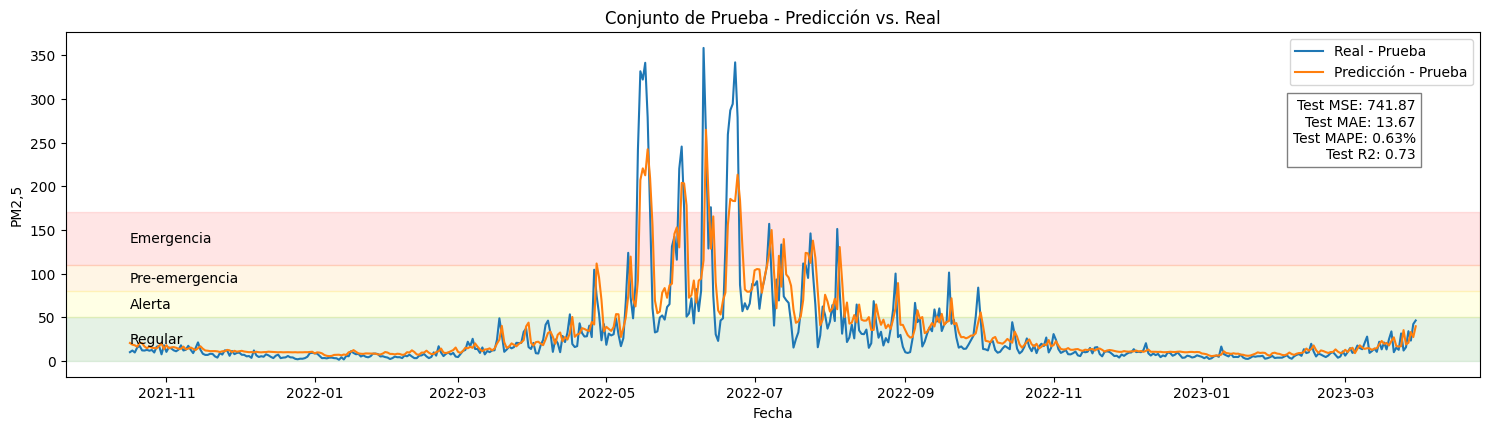

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calcular métricas adicionales para el conjunto de prueba
mse_test = mean_squared_error(y_test, y_predict)
mae_test = mean_absolute_error(y_test, y_predict)
mape_test = mean_absolute_percentage_error(y_test, y_predict)
r2_test = r2_score(y_test, y_predict)

# Graficar predicciones vs. valores reales para el conjunto de prueba
plt.figure(figsize=(15, 8))

# Subplot para mostrar los datos de prueba
plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test.values, label='Real - Prueba')
plt.plot(test_dates, y_predict, label='Predicción - Prueba')
plt.xlabel('Fecha')
plt.ylabel('PM2,5')
plt.title('Conjunto de Prueba - Predicción vs. Real')
plt.legend()

# Resaltar las diferentes áreas de calidad del aire con rectángulos y texto
plt.axhspan(0, 50, color='green', alpha=0.1)
plt.text(test_dates[0], 25, 'Regular', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(50, 80, color='yellow', alpha=0.1)
plt.text(test_dates[0], 65, 'Alerta', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(80, 110, color='orange', alpha=0.1)
plt.text(test_dates[0], 95, 'Pre-emergencia', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(110, 170, color='red', alpha=0.1)
plt.text(test_dates[0], 140, 'Emergencia', fontsize=10, color='black', va='center', ha='left')

# Especificar las coordenadas para las métricas de evaluación
metrics_x = test_dates[-1]  # Coordenada x (fecha)
metrics_y = 300  # Coordenada y

# Mostrar métricas de evaluación en las coordenadas especificadas
metrics_text = f"Test MSE: {mse_test:.2f}\nTest MAE: {mae_test:.2f}\nTest MAPE: {mape_test:.2f}%\nTest R2: {r2_test:.2f}"
plt.text(metrics_x, metrics_y, metrics_text, fontsize=10, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

EN CUANTO EL MAPE SE VA ESTABILIZANDO

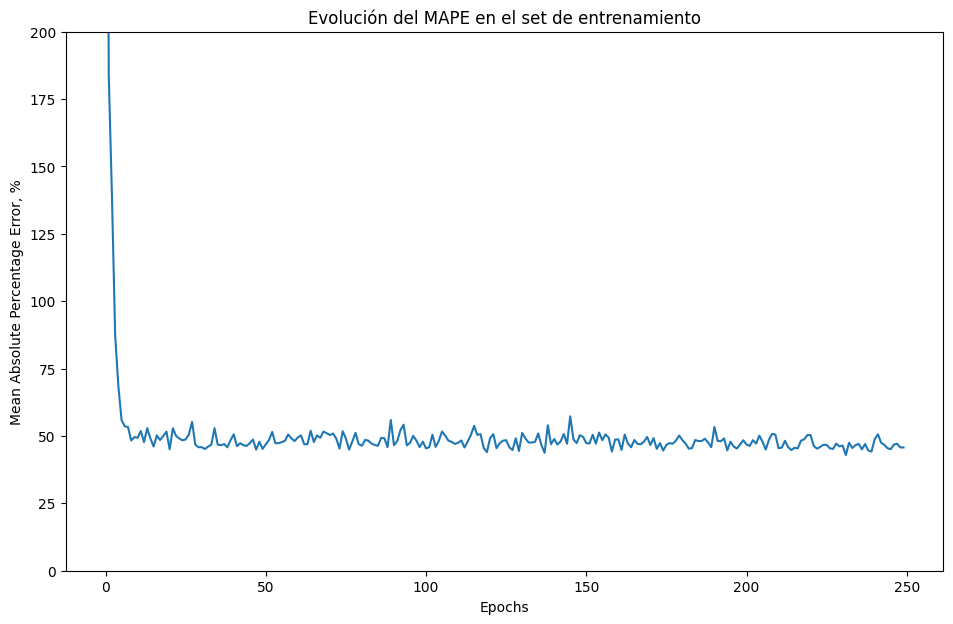

In [ ]:
fig = plt.figure(figsize = (7*(1+np.sqrt(5))/2,7))
plt.plot(MLP.history['mean_absolute_percentage_error'])
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error, %')
plt.title('Evolución del MAPE en el set de entrenamiento')
#plt.yscale('log')
plt.ylim([0,200])
plt.show()

In [ ]:
# Obtener la última fecha en el conjunto de datos de entrenamiento
last_date = df_predictores.index[-1]

# Crear un rango de fechas futuras para los próximos 7 días
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')

# Crear un dataframe vacío con las mismas columnas que df_predictores
future_data = pd.DataFrame(index=future_dates, columns=df_predictores.columns)

# Filtrar los datos del año pasado para el mismo mes
previous_year_data = df_predictores[(df_predictores.index.month == future_dates[0].month) & (df_predictores.index.year == future_dates[0].year - 1)]

# Si no hay datos suficientes, podríamos repetir los datos para rellenar future_data
if len(previous_year_data) < len(future_dates):
    previous_year_data = pd.concat([previous_year_data] * (len(future_dates) // len(previous_year_data) + 1))

# Seleccionar los primeros 7 días de datos del año pasado para rellenar future_data
previous_year_data = previous_year_data.iloc[:len(future_dates)].copy()
previous_year_data.index = future_dates

# Asignar los valores a future_data
future_data[:] = previous_year_data.values

# Añadir DoY y DoW
future_data['DoY'] = future_dates.dayofyear
future_data['DoW'] = future_dates.dayofweek + 1  # Ajustar para que comience en 1 (Lunes=1, Domingo=7)

# Verificar la estructura del DataFrame
print(future_data.head())

           Presion atmosferica hpa Humedad relativa %      PM2,5  \
2023-03-31              963.426708          54.737008      5.125   
2023-04-01              968.287875          67.615342   4.583333   
2023-04-02              963.445833          64.713688   8.166667   
2023-04-03              968.684792          69.991383  11.583333   
2023-04-04              969.545917          67.215038      12.75   

           Temperatura ºc Velocidad del Viento m/s  DoY  DoW  
2023-03-31      13.154975                 6.494529   90    5  
2023-04-01      14.055689                 4.159409   91    6  
2023-04-02      11.649572                 4.441535   92    7  
2023-04-03       7.388352                 4.371187   93    1  
2023-04-04       8.817367                 4.096615   94    2  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


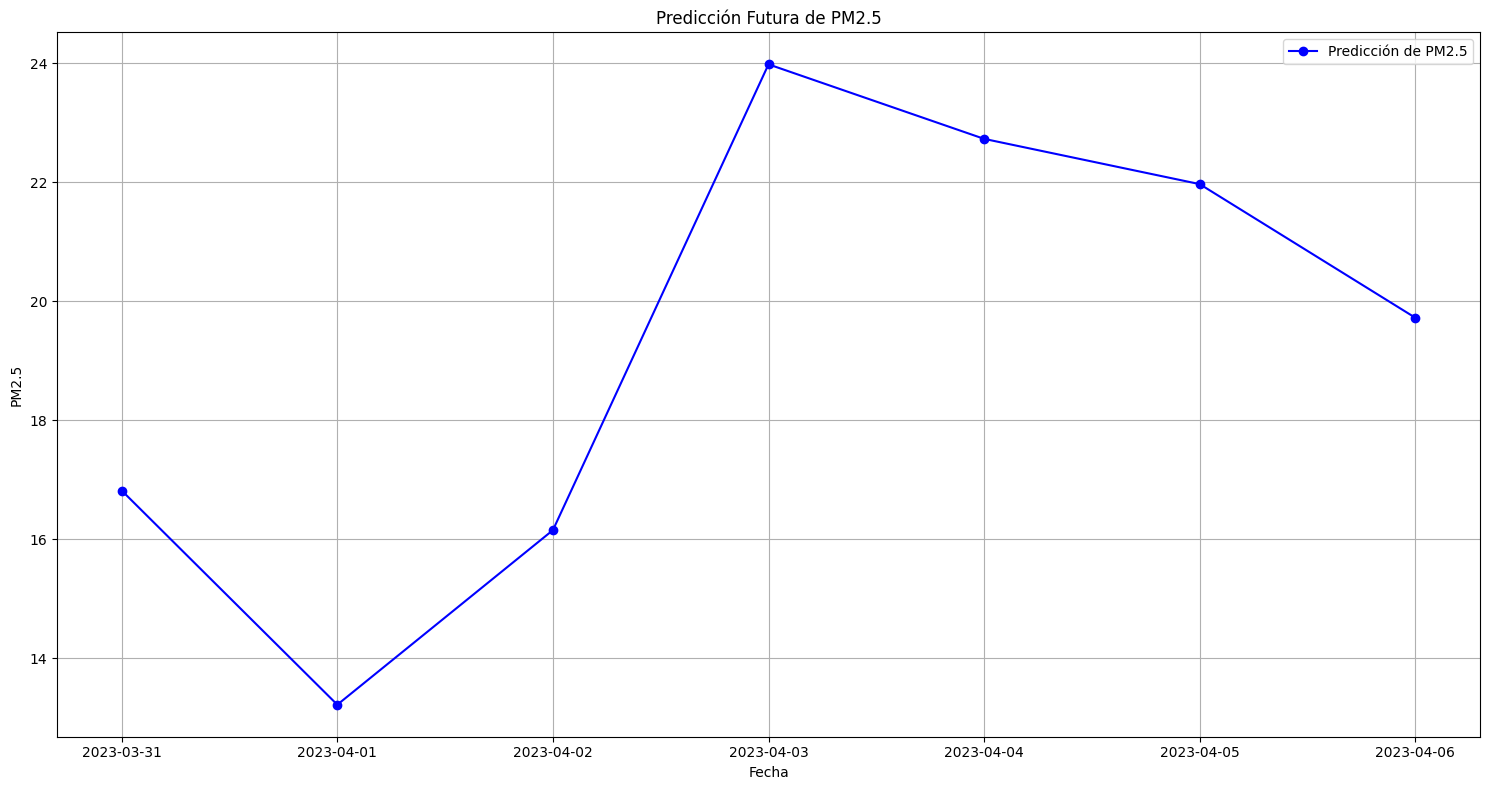

In [ ]:
future_data = future_data.astype(np.float32)

# Realizar predicciones para los datos futuros
future_predictions = model_MLP.predict(future_data)

# Crear un dataframe para almacenar las predicciones futuras
future_df = pd.DataFrame(future_predictions, index=future_data.index, columns=['Predicted PM2.5'])

# Realizar predicciones para los datos futuros
future_predictions = model_MLP.predict(future_data)

# Crear un dataframe para almacenar las predicciones futuras
future_df = pd.DataFrame(future_predictions, index=future_data.index, columns=['Predicted PM2.5'])

# Graficar predicciones futuras de PM2.5
plt.figure(figsize=(15, 8))
plt.plot(future_df.index, future_df['Predicted PM2.5'], marker='o', color='b', label='Predicción de PM2.5')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.title('Predicción Futura de PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


REDES NEURONALES LSTM
---



VOLVEMOS A IMPORTAR LIBRERIAS NECESARIAS

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.layers import LSTM, Dropout, Dense, Conv1D, Attention

REFORMATEAMOS LOS DATOS, porque este modelo requiere una estructura específica para entrenarse y hacer predicciones (secuencial)

In [ ]:
def reshape_for_lstm(data, timesteps, features):
    """
    Reshapes an array into the format required by an LSTM model.

    Args:
        data (numpy.ndarray): Input data array.
        timesteps (int): Number of time steps in the input sequence.
        features (int): Number of features at each time step.

    Returns:
        numpy.ndarray: Reshaped array.
    """
    # Calculate the number of samples
    num_samples = data.shape[0] - timesteps + 1

    # Create an empty array for reshaped data
    reshaped_data = np.zeros((num_samples, timesteps, features))

    # Reshape the data
    for i in range(num_samples):
        reshaped_data[i] = data[i:i + timesteps, :]

    return reshaped_data

MEMORIA DE 3 PERIODOS,  cada secuencia que se pasa al modelo tendrá una longitud de 3 pasos de tiempo.

In [ ]:
#window o ventanas que se va a retroceder los pesos para poder mejorar osea memoria de 3 pasos al pasado
n_steps = 3

# Verifica si 'df_predictores' es la variable correcta
predictores_lstm = reshape_for_lstm(df_predictores.values, n_steps, df_predictores.shape[1])

# Ajusta el target después del reshape
target_lstm = df_target.values[n_steps-1:]

DIVIDIMOS LOS DATOS EN 80% Y 20 %

In [ ]:
# Definir el tamaño del conjunto de entrenamiento como el 80% del total
train_size_lstm = int(len(predictores_lstm) * 0.8)

# División manual de los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_lstm = predictores_lstm[:train_size_lstm]
X_test_lstm = predictores_lstm[train_size_lstm:]

Y_train_lstm = target_lstm[:train_size_lstm]
Y_test_lstm = target_lstm[train_size_lstm:]

# Imprimir las formas de los conjuntos divididos
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("Y_train_lstm shape:", Y_train_lstm.shape)
print("Y_test_lstm shape:", Y_test_lstm.shape)

X_train_lstm shape: (2115, 3, 7)
X_test_lstm shape: (529, 3, 7)
Y_train_lstm shape: (2115,)
Y_test_lstm shape: (529,)


ARQUITECTURA DE LAS REDES LSTM

In [ ]:
model_LSTM = tf.keras.models.Sequential()

model_LSTM.add(Conv1D(filters=128, kernel_size=3,
                      activation= tf.keras.activations.relu,
                      input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2])))

## Capa de LSTM
model_LSTM.add(LSTM(128,
                    activation = tf.keras.activations.relu,
                    return_sequences=True))
model_LSTM.add(LSTM(64,
                    activation = tf.keras.activations.relu,
                    return_sequences=True))
model_LSTM.add(LSTM(32,
                    activation = tf.keras.activations.relu))

## Capa de neuronas clásicas
model_LSTM.add(Dense(32,
                     activation = tf.keras.activations.relu))

## Última capa indica función de la red
model_LSTM.add(Dense(1, activation = tf.keras.activations.linear))

model_LSTM.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['mean_absolute_error','mean_squared_error','mean_absolute_percentage_error'])

model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 128)              │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,313 (770.75 KB)

 Trainable params: 197,313 (770.75 KB)

 Non-trainable params: 0 (0.00 B)

ENTRENAMIENTO LSTM

In [ ]:
lstm_fit = model_LSTM.fit(X_train_lstm, Y_train_lstm, epochs = 250, batch_size = 150)

Epoch 1/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 4933.4248 - mean_absolute_error: 41.7437 - mean_absolute_percentage_error: 82.2811 - mean_squared_error: 4933.4243
Epoch 2/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3473.2249 - mean_absolute_error: 43.8872 - mean_absolute_percentage_error: 245.0069 - mean_squared_error: 3473.2249
Epoch 3/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3159.4812 - mean_absolute_error: 35.9670 - mean_absolute_percentage_error: 163.0017 - mean_squared_error: 3159.4812
Epoch 4/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2367.6716 - mean_absolute_error: 33.9840 - mean_absolute_percentage_error: 181.5582 - mean_squared_error: 2367.6716
Epoch 5/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2186.2678 - mean_absolute_error: 30.3199 - mean_absolute_percentage_error: 128.3781 - mean_squared_error: 2186.2678
Epoch 6/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1744.0814 - mean_absolute_error: 25.1014 - mean_absolute_perc

METRICAS

In [ ]:
# Evaluar el modelo con los datos de prueba
results = model_LSTM.evaluate(X_test_lstm, Y_test_lstm)

# Mostrar todas las métricas devueltas
print(f"Loss: {results[0]}")
print(f"Mean Absolute Error (MAE): {results[1]}")
print(f"Mean Squared Error (MSE): {results[2]}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 724.5923 - mean_absolute_error: 16.8791 - mean_absolute_percentage_error: 115.9933 - mean_squared_error: 724.5923 
Loss: 869.4724731445312
Mean Absolute Error (MAE): 18.87141990661621
Mean Squared Error (MSE): 869.4724731445312


In [ ]:
print(results)

[869.4724731445312, 18.87141990661621, 869.4724731445312, 111.15278625488281]


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


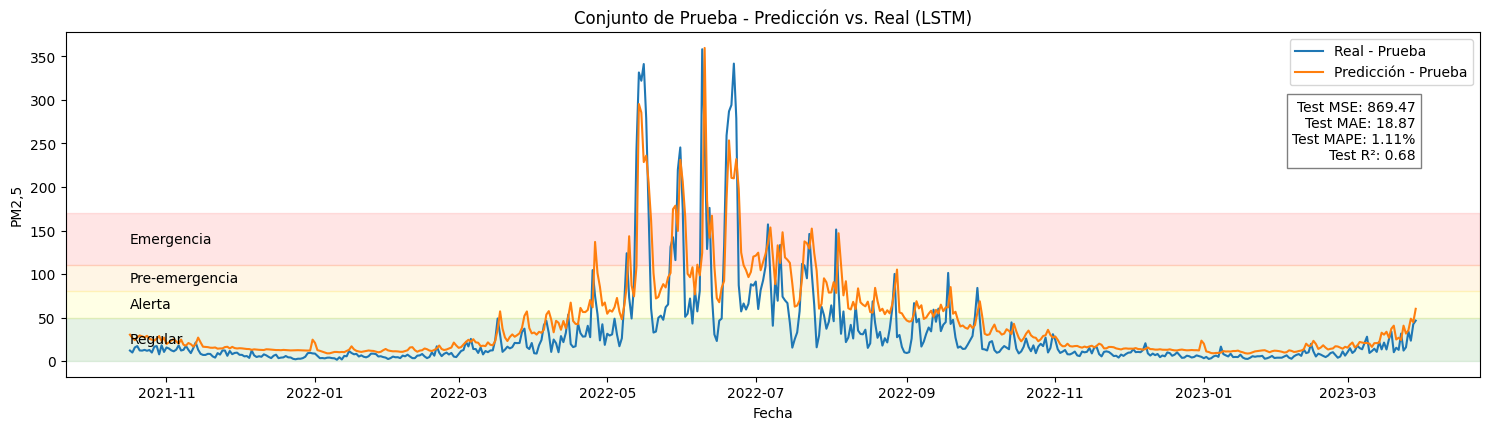

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Asegúrate de que test_dates y Y_test_lstm tengan el mismo número de elementos
test_dates = test_dates[:len(Y_test_lstm)]

# Hacer predicciones con el modelo LSTM
y_pred_lstm = model_LSTM.predict(X_test_lstm)

# Calcular métricas adicionales para el conjunto de prueba
mse_test_lstm = mean_squared_error(Y_test_lstm, y_pred_lstm)
mae_test_lstm = mean_absolute_error(Y_test_lstm, y_pred_lstm)
mape_test_lstm = mean_absolute_percentage_error(Y_test_lstm, y_pred_lstm)
r2_test_lstm = r2_score(Y_test_lstm, y_pred_lstm)

# Graficar predicciones vs. valores reales para el conjunto de prueba
plt.figure(figsize=(15, 8))

# Subplot para mostrar los datos de prueba
plt.subplot(2, 1, 2)
plt.plot(test_dates, Y_test_lstm, label='Real - Prueba')
plt.plot(test_dates, y_pred_lstm, label='Predicción - Prueba')
plt.xlabel('Fecha')
plt.ylabel('PM2,5')
plt.title('Conjunto de Prueba - Predicción vs. Real (LSTM)')
plt.legend()

# Resaltar las diferentes áreas de calidad del aire con rectángulos y texto
plt.axhspan(0, 50, color='green', alpha=0.1)
plt.text(test_dates[0], 25, 'Regular', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(50, 80, color='yellow', alpha=0.1)
plt.text(test_dates[0], 65, 'Alerta', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(80, 110, color='orange', alpha=0.1)
plt.text(test_dates[0], 95, 'Pre-emergencia', fontsize=10, color='black', va='center', ha='left')

plt.axhspan(110, 170, color='red', alpha=0.1)
plt.text(test_dates[0], 140, 'Emergencia', fontsize=10, color='black', va='center', ha='left')

# Especificar las coordenadas para las métricas de evaluación
metrics_x = test_dates[-1]  # Coordenada x (fecha)
metrics_y = 300  # Coordenada y

# Mostrar métricas de evaluación en las coordenadas especificadas
metrics_text = f"Test MSE: {mse_test_lstm:.2f}\nTest MAE: {mae_test_lstm:.2f}\nTest MAPE: {mape_test_lstm:.2f}%\nTest R²: {r2_test_lstm:.2f}"
plt.text(metrics_x, metrics_y, metrics_text, fontsize=10, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

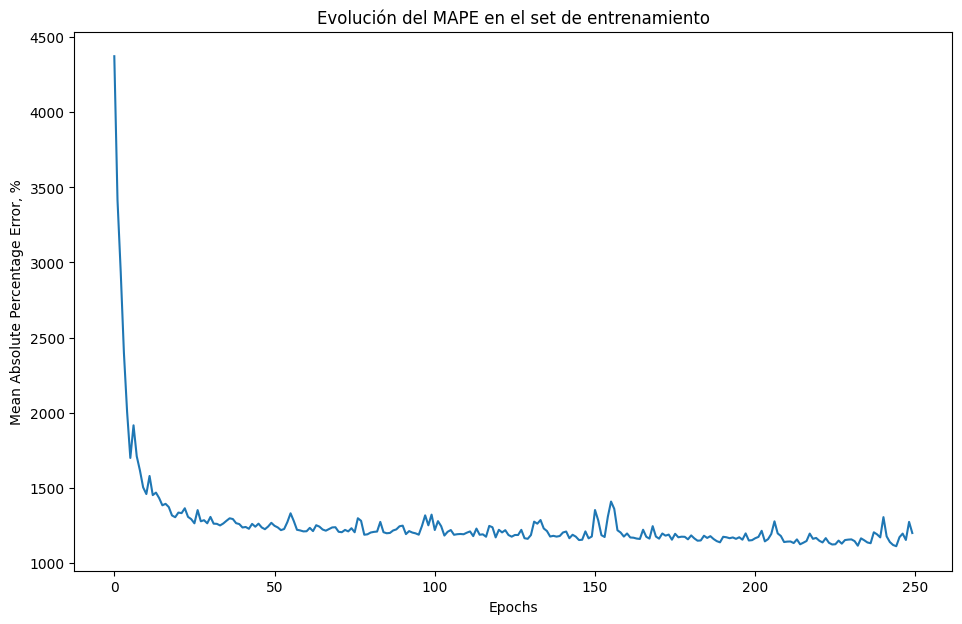

In [ ]:
fig = plt.figure(figsize = (7*(1+np.sqrt(5))/2,7))
#plt.plot(lstm_fit.history['mean_absolute_percentage_error'])
plt.plot(lstm_fit.history['mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error, %')
plt.title('Evolución del MAPE en el set de entrenamiento')
#plt.yscale('log')
#plt.ylim([0,200])
plt.show()


MODELO RANDOM FOREST
---



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler

# Asegúrate de que X_train y X_test son matrices numéricas (si no lo son, usa pd.get_dummies o similares)
X_train = train_data.values  # Si es necesario, convertir a array numérico
X_test = test_data.values

# X_train y X_test deben ser matrices numéricas, lo mismo para y_train y y_test
y_train = train_data1.values
y_test = test_data1.values


#Escalar de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenamiento del modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
rf_model.fit(X_train_scaled, y_train)

# 5. Realizar predicciones
y_pred_rf = rf_model.predict(X_test_scaled)

# 6. Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Imprimir las métricas de evaluación
print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest MAPE: {mape_rf:.2f}%")
print(f"Random Forest R²: {r2_rf:.2f}")



Random Forest MSE: 732.48
Random Forest MAE: 13.03
Random Forest MAPE: 0.55%
Random Forest R²: 0.73


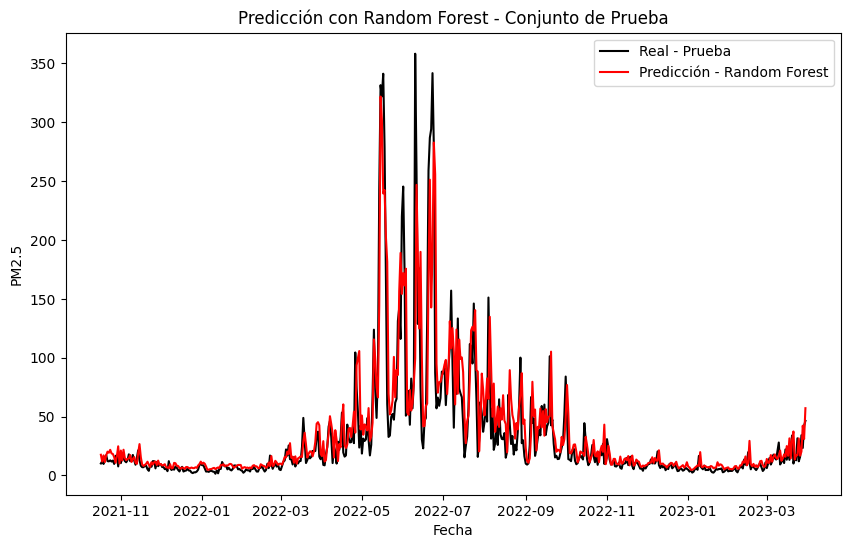

In [ ]:
# 7. Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Real - Prueba', color='black')
plt.plot(test_data.index, y_pred_rf, label='Predicción - Random Forest', color='red')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.title('Predicción con Random Forest - Conjunto de Prueba')
plt.legend()
plt.show()


COMPARACION DE LOS TRES MODELOS
---



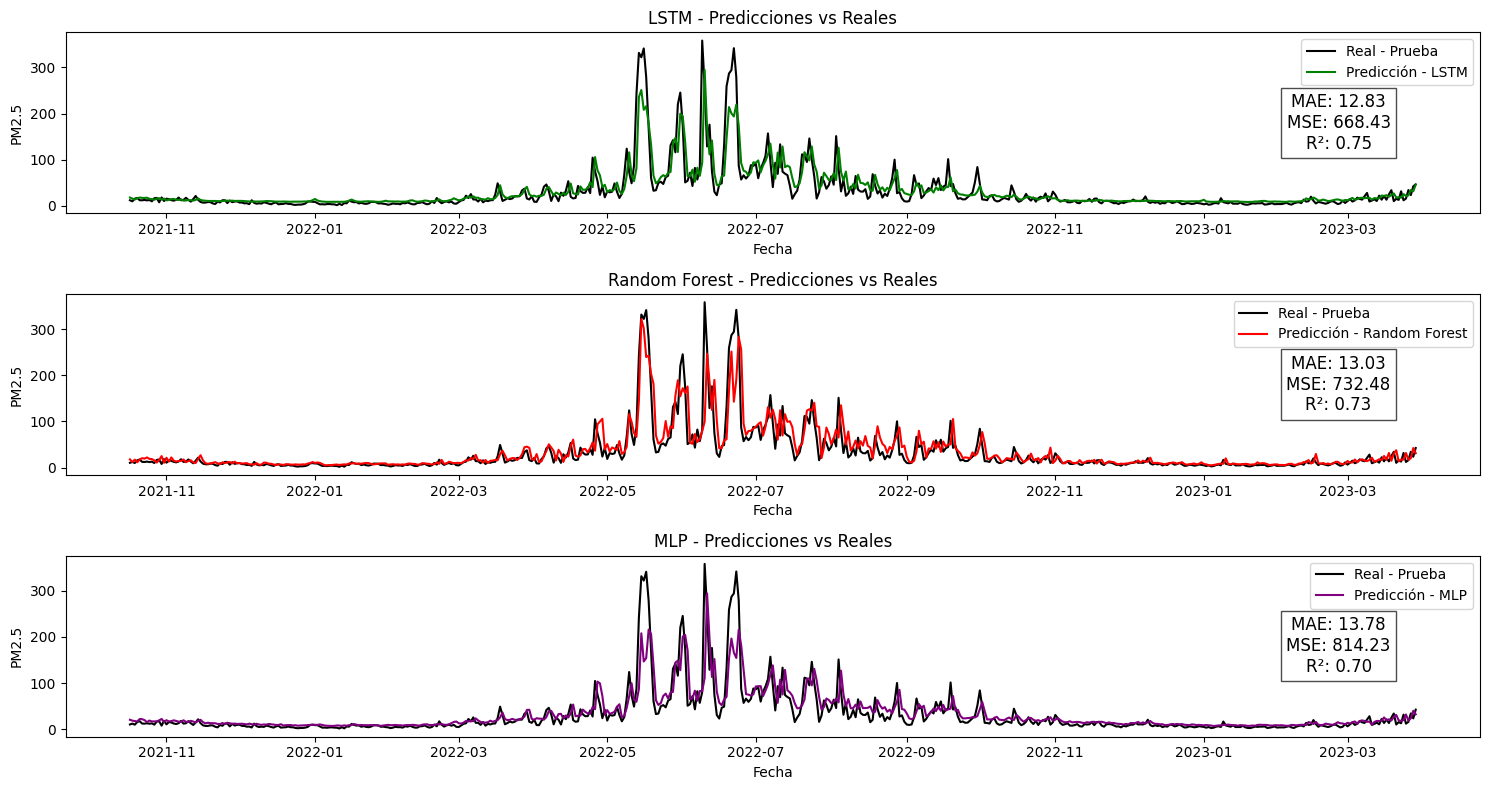

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Graficar los resultados de los tres modelos juntos

plt.figure(figsize=(15, 8))  # Ajuste del tamaño de la figura

# Asegúrate de que test_dates y y_test_lstm tengan la misma longitud para el LSTM
min_length_lstm = min(len(test_dates), len(y_pred_lstm))  # Encontrar la longitud mínima
test_dates_lstm = test_dates[:min_length_lstm]  # Recortar test_dates si es necesario
y_pred_lstm = y_pred_lstm[:min_length_lstm]  # Recortar y_pred_lstm si es necesario

# Gráfico para LSTM
plt.subplot(3, 1, 1)
plt.plot(test_dates_lstm, Y_test_lstm[:min_length_lstm], label='Real - Prueba', color='black')
plt.plot(test_dates_lstm, y_pred_lstm, label='Predicción - LSTM', color='green')
plt.title('LSTM - Predicciones vs Reales')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()

# Mostrar las métricas dentro del gráfico para LSTM
lstm_text = f"MAE: {mae_test_lstm:.2f}\nMSE: {mse_test_lstm:.2f}\nR²: {r2_test_lstm:.2f}"
plt.text(0.9, 0.5, lstm_text, transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Asegúrate de que test_dates y y_test tengan la misma longitud para el Random Forest
min_length_rf = min(len(test_dates), len(y_pred_rf))  # Encontrar la longitud mínima
test_dates_rf = test_dates[:min_length_rf]  # Recortar test_dates si es necesario
y_pred_rf = y_pred_rf[:min_length_rf]  # Recortar y_pred_rf si es necesario

# Gráfico para Random Forest
plt.subplot(3, 1, 2)
plt.plot(test_dates_rf, y_test[:min_length_rf], label='Real - Prueba', color='black')
plt.plot(test_dates_rf, y_pred_rf, label='Predicción - Random Forest', color='red')
plt.title('Random Forest - Predicciones vs Reales')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()

# Mostrar las métricas dentro del gráfico para Random Forest
rf_text = f"MAE: {mae_rf:.2f}\nMSE: {mse_rf:.2f}\nR²: {r2_rf:.2f}"
plt.text(0.9, 0.5, rf_text, transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Asegurarse de que test_dates y y_predict tengan la misma longitud para el MLP
min_length_mlp = min(len(test_dates), len(y_predict))  # Encontrar la longitud mínima
test_dates_mlp = test_dates[:min_length_mlp]  # Recortar test_dates si es necesario
y_predict_mlp = y_predict[:min_length_mlp]  # Recortar y_predict si es necesario

# Gráfico para MLP
plt.subplot(3, 1, 3)
plt.plot(test_dates_mlp, y_test[:min_length_mlp], label='Real - Prueba', color='black')
plt.plot(test_dates_mlp, y_predict_mlp, label='Predicción - MLP', color='purple')
plt.title('MLP - Predicciones vs Reales')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.legend()

# Mostrar las métricas dentro del gráfico para MLP
mlp_text = f"MAE: {mae_test:.2f}\nMSE: {mse_test:.2f}\nR²: {r2_test:.2f}"
plt.text(0.9, 0.5, mlp_text, transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()
